Learning source: https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

In [ ]:
import numpy as np
import torch
from torch import nn
from PIL import image
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

ImportError: ignored

Defining the train/validation dataset loader, using the SubsetRandomSampler for the split.

**torchvision.transforms in PyTorch**

Transforms are common image transformations. They can be chanined together with using Compose.

All transformations accept PIL Image, Tensor Image or batch of Tensor Images as input. 

Tensor Image is a tensor with (C, H, W) shape, where C is a number of channels, H and W are image height and width. Batch of Tensor Images is a tensor of (B, C, H, W) shape, where B is a number of images in the batch. 


**Scriptable transforms**
In order to script the transformations, use torch.nn.Sequential instead of Compose.

In [ ]:
transforms = torch.nn.Sequential(transforms.CenterCrop(10), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),)
scripted_transforms = torch.jit.script(transforms)

For any custom transformations to be used with torch.jit.script, they should be derived from torch.nn.Module.

torchvision.transforms.ToTensor

It converts a PIL Image or numpy.ndarrary to tensor. This transformation does not support torchscript.
It coverts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8

In other cases, tensors are returned without scaling. 

Note: Because the input image is scaled to [0.0, 1.0], this transformation should not be used when transforming target masks

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/IC Note Images/Train'

def load_split_train_test(datadir, valid_size = .2):
  train_transforms = torchvision.transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor(),])
  test_transforms = torchvision.transforms.Compose([transforms.Resize((150, 150)), transforms.ToTensor(),])

  train_data = datasets.ImageFolder(datadir, transform = train_transforms)
  test_data = datasets.ImageFolder(datadir, transform = test_transforms)

  num_train = len(train_data)
  indices = list(range(num_train))
  split = int(np.floor(valid_size*num_train))
  np.random.shuffle(indices)
  train_idx, test_idx = indices[split:], indices[:split]
  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler = SubsetRandomSampler(test_idx)
  trainloader = torch.utils.data.DataLoader(train_data, sampler = train_sampler, batch_size = 6)
  testloader = torch.utils.data.DataLoader(test_data, sampler = test_sampler, batch_size = 6)

  print(test_transforms)
  print(test_data)
  return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)
print(testloader.dataset.classes)


Compose(
    Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
    ToTensor()
)
Dataset ImageFolder
    Number of datapoints: 153
    Root location: /content/drive/MyDrive/Colab Notebooks/IC Note Images/Train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
['1Hundrednote', '2Hundrednote', '2Thousandnote', '5Hundrednote', 'Fiftynote', 'Tennote', 'Twentynote']
['1Hundrednote', '2Hundrednote', '2Thousandnote', '5Hundrednote', 'Fiftynote', 'Tennote', 'Twentynote']


Now, let's determine whether we have GPU or not. 

Also, we can load a pretrained model such as ResNet 50 in this case.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [ ]:
for param in model.parameters():
  param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(2048, 512),
                         nn.ReLU(), 
                         nn.Dropout(0.2),
                         nn.Linear(512, 7),
                         nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
epochs = 5
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
  for inputs, labels in trainloader:
    steps+=1
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    logps = model.forward(inputs)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()

    if steps % print_every ==0:
      test_loss = 0
      accuracy = 0
      model.eval()
      with torch.no_grad():
        for inputs, labels in testloader:
          inputs, labels = inputs.to(device), labels.to(device)
          logps = model.forward(inputs)
          batch_loss = criterion(logps, labels)
          test_loss += batch_loss.item()
          ps = torch.exp(logps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
      
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(testloader))
      print(f"Epoch {epoch+1}/{epochs}.." 
            f"Train loss: {running_loss/print_every: .3f} .."
            f"Test loss: {test_loss/len(testloader):.3f}.."
            f"Test accuracy: {accuracy/len(testloader):.3f}")
      running_loss = 0
      model.train()
torch.save(model, 'aerialmodel.pth')

Epoch 1/5..Train loss:  1.297 ..Test loss: 1.199..Test accuracy: 0.567
Epoch 1/5..Train loss:  0.952 ..Test loss: 1.457..Test accuracy: 0.500
Epoch 2/5..Train loss:  0.938 ..Test loss: 1.010..Test accuracy: 0.600
Epoch 2/5..Train loss:  1.225 ..Test loss: 0.839..Test accuracy: 0.700
Epoch 3/5..Train loss:  0.973 ..Test loss: 1.186..Test accuracy: 0.600
Epoch 3/5..Train loss:  0.948 ..Test loss: 1.623..Test accuracy: 0.300
Epoch 4/5..Train loss:  1.367 ..Test loss: 0.951..Test accuracy: 0.700
Epoch 4/5..Train loss:  1.136 ..Test loss: 1.239..Test accuracy: 0.567
Epoch 5/5..Train loss:  0.701 ..Test loss: 1.169..Test accuracy: 0.633
Epoch 5/5..Train loss:  0.798 ..Test loss: 0.740..Test accuracy: 0.800


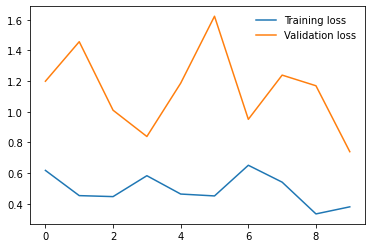

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

The function that predicts the class of a specific image is very simple. Note that it requires a pillow image, not a file path.

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/IC Note Images/Test'


test_transforms = transforms.Compose([transforms.Resize((150, 150)),transforms.ToTensor(),])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('aerialmodel.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    # input = Variable(image_tensor)
    input = image_tensor
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

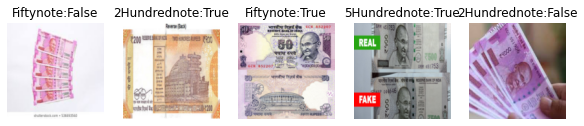

In [ ]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(trainloader.dataset.classes[index]) + ':' + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()
